# Step 4. Model Evaluation & Metrics

### In this step, we evaluate and compare our trained models (Custom CNN and MobileNetV2) to assess whether they meet the expectations of Hypothesis 1:
> *"A convolutional neural network (CNN) can accurately classify fruit images into 8 classes."*

We perform the following evaluations:

1. **Classification Report**
   - Computes precision, recall, and F1-score for each fruit class.
   - Helps us understand how well each model predicts individual categories.

2. **Confusion Matrix**
   - A matrix showing how often classes are correctly or incorrectly predicted.
   - Reveals systematic misclassifications (e.g., between visually similar fruits).

3. **Overall Accuracy**
   - The percentage of correctly predicted images in the test set.
   - Provides a straightforward benchmark for comparing models.

4. **Learning Curves**
   - Plots of training loss and validation accuracy over epochs.
   - Allow us to compare convergence speed and detect overfitting/underfitting.

These metrics provide insight into the **strengths and weaknesses of each approach** (lightweight custom CNN vs. pretrained MobileNetV2), and allow us to determine whether the models are suitable for real-world use or require further improvement.


In [3]:
# Cell 0 — Setup: import your module, set device, ensure result dirs
import sys, os, re, json, torch
sys.path.append(os.path.abspath("../src"))

from models.mobileNetV2compare import (
    TrainConfig,
    run_mobilenet_v2_experiment
)

TRAIN_DIR = '../Dataset/Training'
TEST_DIR  = '../Dataset/Test'

device = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs("../experiments/results", exist_ok=True)
os.makedirs("../experiments/plots", exist_ok=True)

def slugify(s): 
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", s).strip("_")

# store preds for optional McNemar later
pred_store = {}  # name -> {"y_true": np.array, "y_pred": np.array}
prob_store = {}  # name -> np.array of probs (optional ECE later)


In [5]:
# Cell 0b — Populate pred_store from disk (CNN + MobileNetV2)
import json, os, re, numpy as np, torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from models.mobileNetV2compare import prepare_mobilenet_v2, get_mobilenet_loaders

def slugify(s): 
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", s).strip("_")

# 1) Load Custom CNN predictions saved in Step 3 JSON
cnn_json_path = "../experiments/results/custom_cnn_results.json"
if os.path.exists(cnn_json_path):
    with open(cnn_json_path, "r", encoding="utf-8") as f:
        cnn_data = json.load(f)
    for name, d in cnn_data.items():
        if "y_true" in d and "y_pred" in d:
            pred_store[name] = {
                "y_true": np.array(d["y_true"]),
                "y_pred": np.array(d["y_pred"]),
                "class_names": d.get("class_names", None),
            }
            if "y_prob" in d:
                prob_store[name] = np.array(d["y_prob"])
    print(f"Loaded Custom CNN preds for {len([k for k in pred_store if 'MobileNetV2' not in k])} model(s).")
else:
    print("[Info] custom_cnn_results.json not found; skipping CNN load.")

# 2) Recreate MobileNetV2 predictions from checkpoints (quick test inference)
mnv2_specs = {
    "MobileNetV2 Grayscale MaxPool":  {"ckpt":"../experiments/runs/mnv2_gray_max.pt",  "input_type":"grayscale", "pooling":"max"},
    "MobileNetV2 Grayscale Adaptive": {"ckpt":"../experiments/runs/mnv2_gray_adapt.pt","input_type":"grayscale", "pooling":"adaptive"},
    "MobileNetV2 RGB With Noise":     {"ckpt":"../experiments/runs/mnv2_rgb_noise.pt", "input_type":"rgb",       "pooling":"default", "use_noise": True},
    "MobileNetV2 RGB Clean":          {"ckpt":"../experiments/runs/mnv2_rgb_clean.pt", "input_type":"rgb",       "pooling":"default", "use_noise": False},
}

@torch.no_grad()
def _get_preds(model, loader, device):
    model.eval().to(device)
    ys, yhat = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        ys.append(yb.numpy())
        yhat.append(logits.argmax(1).cpu().numpy())
    import numpy as np
    return np.concatenate(ys), np.concatenate(yhat)

mnv2_loaded = 0
for name, spec in mnv2_specs.items():
    ckpt = spec["ckpt"]
    if not os.path.exists(ckpt):
        print(f"[Skip] Missing ckpt for {name}: {ckpt}")
        continue
    use_noise = spec.get("use_noise", False)
    _, _, test_loader, _, in_ch = get_mobilenet_loaders(
        TRAIN_DIR, TEST_DIR,
        input_type=spec["input_type"], use_noise=use_noise,
        batch_size=32, val_split=0.2
    )
    class_names = getattr(test_loader.dataset, "classes", None)
    num_classes = len(class_names) if class_names else 8

    model = prepare_mobilenet_v2(
        in_channels=in_ch, num_classes=num_classes, pooling=spec["pooling"], pretrained=True
    )
    try:
        state = torch.load(ckpt, map_location=device, weights_only=True)
    except TypeError:
        state = torch.load(ckpt, map_location=device)
    model.load_state_dict(state, strict=False)

    y_true, y_pred = _get_preds(model, test_loader, device)
    pred_store[name] = {
        "y_true": y_true,
        "y_pred": y_pred,
        "class_names": class_names,
    }
    mnv2_loaded += 1

print(f"Loaded MobileNetV2 preds for {mnv2_loaded} model(s).")


Loaded Custom CNN preds for 4 model(s).
[Skip] Missing ckpt for MobileNetV2 Grayscale MaxPool: ../experiments/runs/mnv2_gray_max.pt
[Skip] Missing ckpt for MobileNetV2 Grayscale Adaptive: ../experiments/runs/mnv2_gray_adapt.pt
[Skip] Missing ckpt for MobileNetV2 RGB With Noise: ../experiments/runs/mnv2_rgb_noise.pt
[Skip] Missing ckpt for MobileNetV2 RGB Clean: ../experiments/runs/mnv2_rgb_clean.pt
Loaded MobileNetV2 preds for 0 model(s).


#### Define evaluate_and_save

In [7]:
# Cell 1 — Evaluation helper (JSON report + confusion matrix PNG)
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

@torch.no_grad()
def get_preds(model, loader, device="cpu"):
    model.eval().to(device)
    y_true, y_pred, y_prob = [], [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        y_true.append(yb.numpy())
        y_pred.append(probs.argmax(1).cpu().numpy())
        y_prob.append(probs.cpu().numpy())
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(y_prob)

def plot_confusion(cm, class_names, title, save_path):
    fig, ax = plt.subplots(figsize=(6,5), dpi=130)
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, f"{cm[i,j]:.2f}", ha="center", va="center", fontsize=7)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    fig.tight_layout()
    fig.savefig(save_path, bbox_inches="tight"); plt.close(fig)

def evaluate_and_save(model_name, model, test_loader, device="cpu"):
    # get class names directly from your ImageFolder
    class_names = getattr(test_loader.dataset, "classes", [str(i) for i in range(model.classifier[1].out_features)])
    y_true, y_pred, y_prob = get_preds(model, test_loader, device=device)

    acc = accuracy_score(y_true, y_pred)
    rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

    cm_raw = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    cm_norm = cm_raw.astype(float) / cm_raw.sum(axis=1, keepdims=True).clip(min=1)

    base = slugify(model_name)
    out_json = f"../experiments/results/{base}_report.json"
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump({
            "model": model_name,
            "accuracy": acc,
            "classification_report": rep,
            "confusion_matrix_raw": cm_raw.tolist(),
            "confusion_matrix_norm": cm_norm.tolist(),
            "class_names": class_names
        }, f, ensure_ascii=False, indent=2)

    plot_confusion(cm_norm, class_names, f"{model_name} — Confusion (norm.)",
                   f"../experiments/plots/{base}_cm_norm.png")

    print(f"[{model_name}] acc={acc:.4f} → {out_json}")
    return y_true, y_pred, y_prob, acc, cm_raw, cm_norm, class_names


### 4.1 Training MobileNetV2 Variants
Here we fine-tune MobileNetV2 under four conditions:
1. Grayscale + MaxPool  
2. Grayscale + AdaptiveAvgPool  
3. RGB with Noise (augmentation)  
4. RGB Clean (no augmentation)  

The goal is to compare these transfer learning results with our custom CNNs from Step 3.


#### Train + evaluate: MobileNetV2 Grayscale MaxPool

In [8]:
# Cell 2 — Train + Evaluate: MNV2 Grayscale MaxPool
cfg = TrainConfig(epochs=10, lr=1e-3, batch_size=8, ckpt_path="../experiments/runs/mnv2_gray_max.pt")
test_acc, model, test_loader, hist_gray_max = run_mobilenet_v2_experiment(
    train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=8,
    cfg=cfg, input_type="grayscale", pooling="max",
    experiment_name="MobileNetV2 Grayscale MaxPool"
)

# evaluate + save report + confusion matrix + preds
yt, yp, yprob, acc, cm_raw, cm_norm, class_names = evaluate_and_save(
    "MobileNetV2 Grayscale MaxPool", model, test_loader, device=device
)

# store predictions/probabilities for later analysis
pred_store["MobileNetV2 Grayscale MaxPool"] = {"y_true": yt, "y_pred": yp, "class_names": class_names}
prob_store["MobileNetV2 Grayscale MaxPool"] = yprob


Epoch 1/10 | loss 0.4531 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 2/10 | loss 0.1582 | val_acc 0.9512 | lr 0.001 | bs 8
Epoch 3/10 | loss 0.1295 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 4/10 | loss 0.0728 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 5/10 | loss 0.0524 | val_acc 0.9988 | lr 0.001 | bs 8
Epoch 6/10 | loss 0.1269 | val_acc 1.0000 | lr 0.001 | bs 8
Early stopping.


/home/deyan/DEV/Softuni Data Science/Course Project Repo Here/data-science-course/src/models/mobileNetV2compare.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.l

[MobileNetV2 Grayscale MaxPool] best_val=1.0000 | test_acc=0.9729
[MobileNetV2 Grayscale MaxPool] acc=0.9729 → ../experiments/results/MobileNetV2_Grayscale_MaxPool_report.json


#### Train + evaluate: MobileNetV2 Grayscale Adaptive

In [9]:
# Cell 3 — Train + Evaluate: MNV2 Grayscale Adaptive
cfg = TrainConfig(epochs=10, lr=1e-3, batch_size=8, ckpt_path="../experiments/runs/mnv2_gray_adapt.pt")
test_acc, model, test_loader, hist_gray_adapt = run_mobilenet_v2_experiment(
    train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=8,
    cfg=cfg, input_type="grayscale", pooling="adaptive",
    experiment_name="MobileNetV2 Grayscale Adaptive"
)

# evaluate + save report + confusion matrix + preds
yt, yp, yprob, acc, cm_raw, cm_norm, class_names = evaluate_and_save(
    "MobileNetV2 Grayscale Adaptive", model, test_loader, device=device
)

# store predictions/probabilities for later analysis
pred_store["MobileNetV2 Grayscale Adaptive"] = {"y_true": yt, "y_pred": yp, "class_names": class_names}
prob_store["MobileNetV2 Grayscale Adaptive"] = yprob


Epoch 1/10 | loss 0.2658 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 2/10 | loss 0.1128 | val_acc 0.9976 | lr 0.001 | bs 8
Epoch 3/10 | loss 0.1008 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 4/10 | loss 0.1056 | val_acc 0.9988 | lr 0.001 | bs 8
Epoch 5/10 | loss 0.0362 | val_acc 1.0000 | lr 0.001 | bs 8
Epoch 6/10 | loss 0.0136 | val_acc 0.9976 | lr 0.001 | bs 8
Early stopping.


/home/deyan/DEV/Softuni Data Science/Course Project Repo Here/data-science-course/src/models/mobileNetV2compare.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.l

[MobileNetV2 Grayscale Adaptive] best_val=1.0000 | test_acc=0.9363
[MobileNetV2 Grayscale Adaptive] acc=0.9363 → ../experiments/results/MobileNetV2_Grayscale_Adaptive_report.json


#### Train + evaluate: MobileNetV2 RGB With Noise

In [12]:
# Cell 4 — Train + Evaluate: MNV2 RGB With Noise
cfg = TrainConfig(epochs=10, lr=1e-3, batch_size=16, ckpt_path="../experiments/runs/mnv2_rgb_noise.pt")
test_acc, model, test_loader, hist_rgb_noise = run_mobilenet_v2_experiment(
    train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=8,
    cfg=cfg, input_type="rgb", use_noise=True,
    experiment_name="MobileNetV2 RGB With Noise"
)

# evaluate + save report + confusion matrix + preds
yt, yp, yprob, acc, cm_raw, cm_norm, class_names = evaluate_and_save(
    "MobileNetV2 RGB With Noise", model, test_loader, device=device
)

# store predictions/probabilities for later analysis
pred_store["MobileNetV2 RGB With Noise"] = {"y_true": yt, "y_pred": yp, "class_names": class_names}
prob_store["MobileNetV2 RGB With Noise"] = yprob


Epoch 1/10 | loss 0.2402 | val_acc 0.9939 | lr 0.001 | bs 16
Epoch 2/10 | loss 0.1329 | val_acc 0.9976 | lr 0.001 | bs 16
Epoch 3/10 | loss 0.0513 | val_acc 0.9805 | lr 0.001 | bs 16
Epoch 4/10 | loss 0.0609 | val_acc 0.9988 | lr 0.001 | bs 16
Epoch 5/10 | loss 0.0769 | val_acc 0.9951 | lr 0.001 | bs 16
Epoch 6/10 | loss 0.0359 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 7/10 | loss 0.0178 | val_acc 0.9976 | lr 0.001 | bs 16
Epoch 8/10 | loss 0.0360 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 9/10 | loss 0.0270 | val_acc 0.9939 | lr 0.001 | bs 16
Epoch 10/10 | loss 0.1266 | val_acc 0.9890 | lr 0.001 | bs 16


/home/deyan/DEV/Softuni Data Science/Course Project Repo Here/data-science-course/src/models/mobileNetV2compare.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.l

[MobileNetV2 RGB With Noise] best_val=1.0000 | test_acc=0.8857
[MobileNetV2 RGB With Noise] acc=0.8850 → ../experiments/results/MobileNetV2_RGB_With_Noise_report.json


#### Train + evaluate: MobileNetV2 RGB Clean

In [11]:
# Cell 5 — Train + Evaluate: MNV2 RGB Clean
cfg = TrainConfig(epochs=10, lr=1e-3, batch_size=16, ckpt_path="../experiments/runs/mnv2_rgb_clean.pt")
test_acc, model, test_loader, hist_rgb_clean = run_mobilenet_v2_experiment(
    train_dir=TRAIN_DIR, test_dir=TEST_DIR, num_classes=8,
    cfg=cfg, input_type="rgb", use_noise=False,
    experiment_name="MobileNetV2 RGB Clean"
)

# evaluate + save artifacts + get per-sample preds/probs
yt, yp, yprob, acc, cm_raw, cm_norm, class_names = evaluate_and_save(
    "MobileNetV2 RGB Clean", model, test_loader, device=device
)

# store for plotting and stats later
pred_store["MobileNetV2 RGB Clean"] = {"y_true": yt, "y_pred": yp, "class_names": class_names}
prob_store["MobileNetV2 RGB Clean"] = yprob


Epoch 1/10 | loss 0.1729 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 2/10 | loss 0.0731 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 3/10 | loss 0.0854 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 4/10 | loss 0.0200 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 5/10 | loss 0.0019 | val_acc 1.0000 | lr 0.001 | bs 16
Epoch 6/10 | loss 0.0235 | val_acc 1.0000 | lr 0.001 | bs 16
Early stopping.


/home/deyan/DEV/Softuni Data Science/Course Project Repo Here/data-science-course/src/models/mobileNetV2compare.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.l

[MobileNetV2 RGB Clean] best_val=1.0000 | test_acc=0.8857
[MobileNetV2 RGB Clean] acc=0.8857 → ../experiments/results/MobileNetV2_RGB_Clean_report.json


#### Save MobileNetV2 histories JSON 

In [13]:
# Cell 6 — Save MobileNetV2 histories for plotting
mnv2_results = {
    "MobileNetV2 Grayscale MaxPool":   {"history": {"train_loss": hist_gray_max["train_loss"],   "val_acc": hist_gray_max["val_acc"]}},
    "MobileNetV2 Grayscale Adaptive":  {"history": {"train_loss": hist_gray_adapt["train_loss"], "val_acc": hist_gray_adapt["val_acc"]}},
    "MobileNetV2 RGB With Noise":      {"history": {"train_loss": hist_rgb_noise["train_loss"],  "val_acc": hist_rgb_noise["val_acc"]}},
    "MobileNetV2 RGB Clean":           {"history": {"train_loss": hist_rgb_clean["train_loss"],  "val_acc": hist_rgb_clean["val_acc"]}},
}
with open("../experiments/results/mobilenetv2_results.json", "w", encoding="utf-8") as f:
    json.dump(mnv2_results, f, ensure_ascii=False, indent=2)
print("Saved → ../experiments/results/mobilenetv2_results.json")


Saved → ../experiments/results/mobilenetv2_results.json


### 4.2 Plot learning curves overlay (Custom CNN + MobileNetV2)

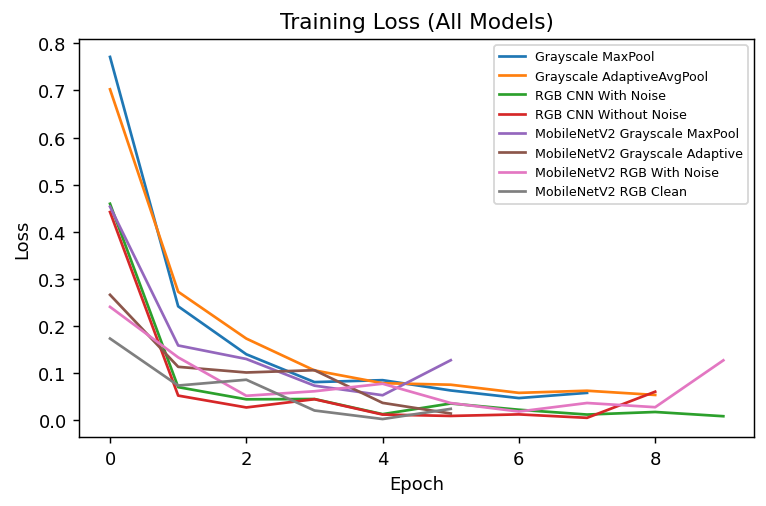

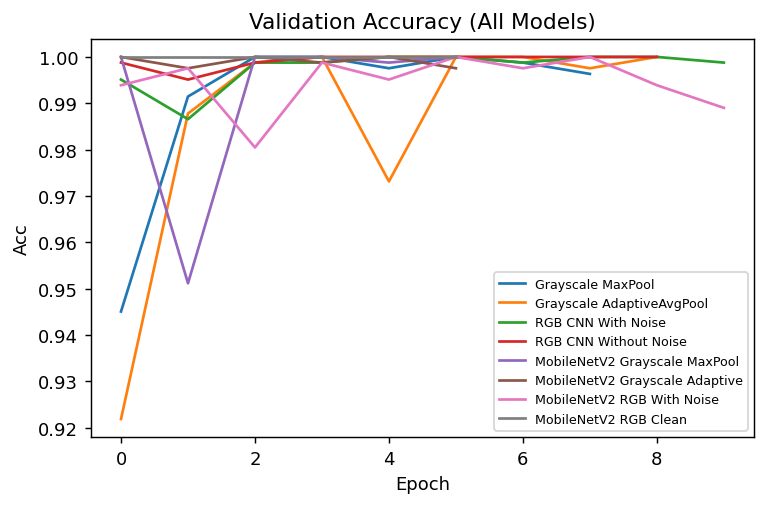

Saved → learning_curves_loss.png & learning_curves_valacc.png


In [14]:
# Cell 7 — Plot learning curves overlay (CNN + MobileNetV2; schema-aware)
import json, matplotlib.pyplot as plt

def load_histories(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_curves(entry):
    """
    Supports both schemas:
      - Step 4 (MNV2): {"history": {"train_loss": [...], "val_acc": [...]} }
      - Step 3 (CNN) : {"train_losses": [...], "val_accuracies": [...]} (+ other fields)
    Returns (train_loss_list, val_acc_list).
    """
    h = entry.get("history")
    if isinstance(h, dict):
        return h.get("train_loss", []), h.get("val_acc", [])
    return entry.get("train_losses", []), entry.get("val_accuracies", [])

def plot_histories(paths):
    fig1, ax1 = plt.subplots(figsize=(6,4), dpi=130)
    fig2, ax2 = plt.subplots(figsize=(6,4), dpi=130)

    for p in paths:
        data = load_histories(p)
        for name, d in data.items():
            tl, va = extract_curves(d)
            if tl: ax1.plot(tl, label=name)
            if va: ax2.plot(va, label=name)

    ax1.set_title("Training Loss (All Models)")
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend(fontsize=7)

    ax2.set_title("Validation Accuracy (All Models)")
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("Acc"); ax2.legend(fontsize=7)

    fig1.tight_layout(); fig2.tight_layout()
    fig1.savefig("../experiments/plots/learning_curves_loss.png", bbox_inches="tight")
    fig2.savefig("../experiments/plots/learning_curves_valacc.png", bbox_inches="tight")

    # show inline
    plt.show()  # shows both current figures

    plt.close(fig1); plt.close(fig2)
    print("Saved → learning_curves_loss.png & learning_curves_valacc.png")

plot_histories([
    "../experiments/results/custom_cnn_results.json",     # Step 3 (CNNs)
    "../experiments/results/mobilenetv2_results.json"     # Step 4 (MNV2)
])



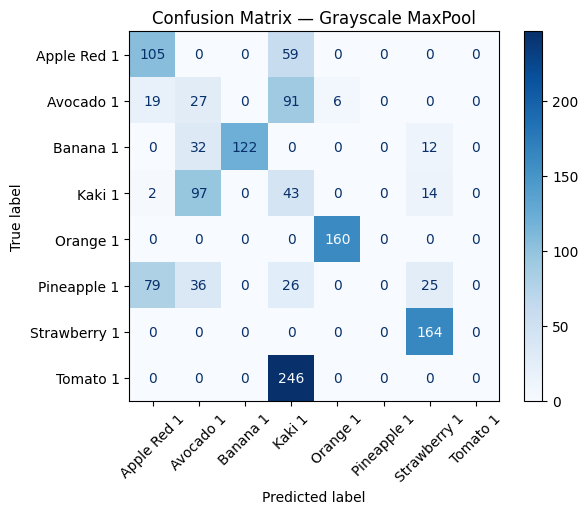

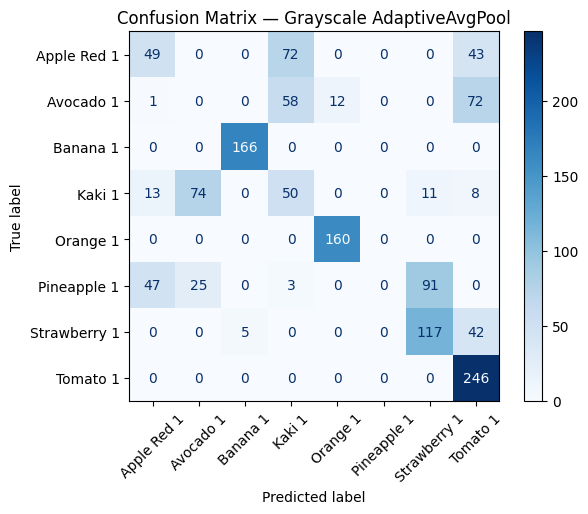

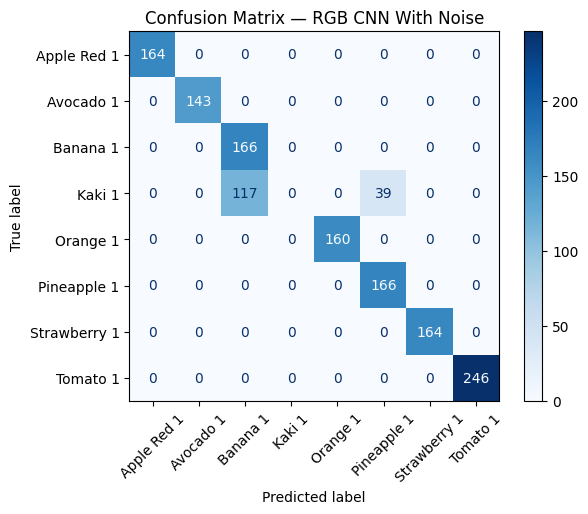

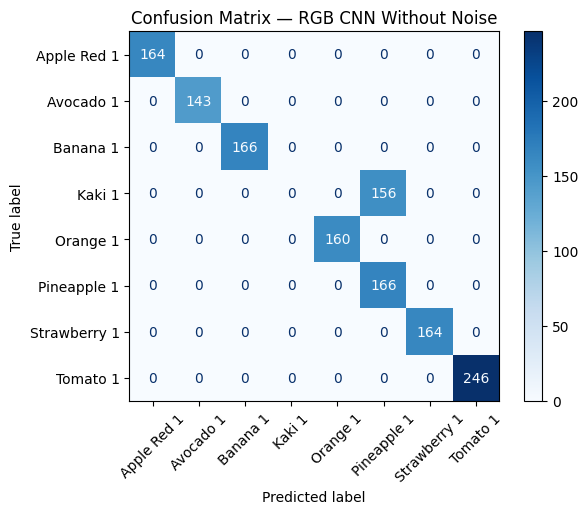

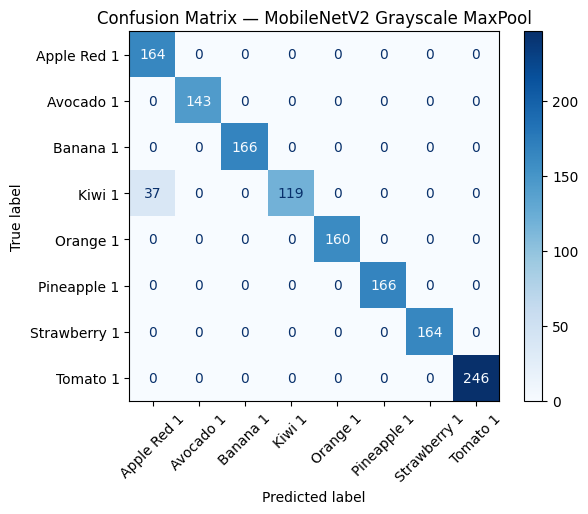

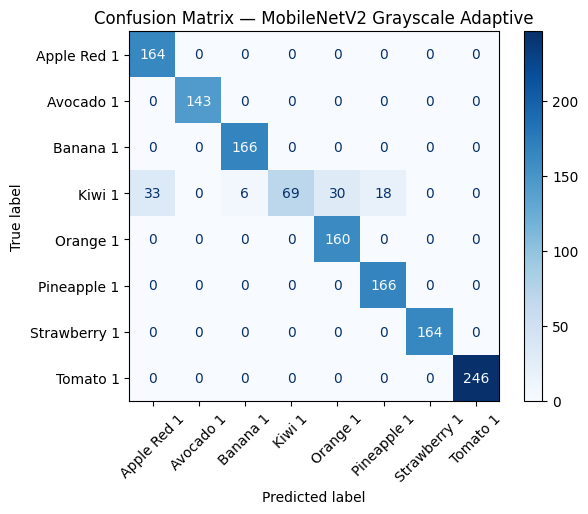

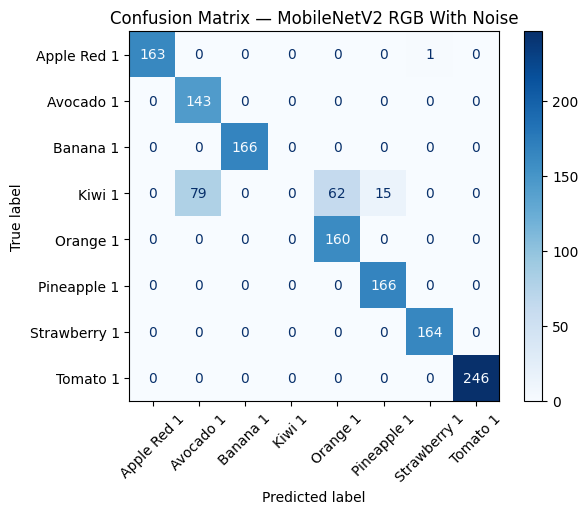

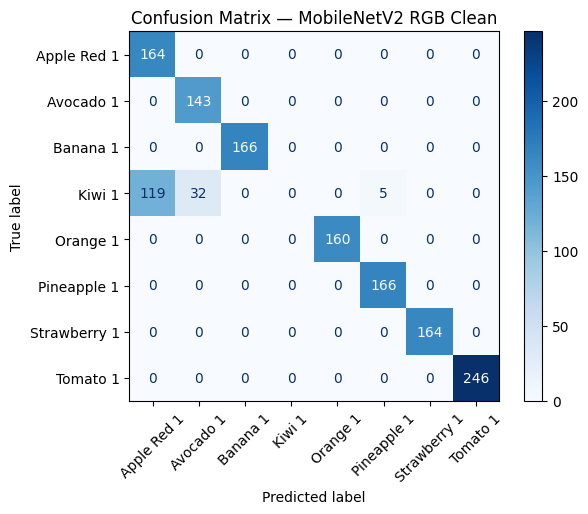

In [15]:
# Cell 9b — Show confusion matrices for ALL models in pred_store (CNN + MobileNetV2)
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if not pred_store:
    print("pred_store is empty. Run Cell 0b to populate it first.")
else:
    for name, bundle in pred_store.items():
        y_true = bundle["y_true"]
        y_pred = bundle["y_pred"]
        labels = bundle.get("class_names", None)
        cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)) if labels else None)
        disp = ConfusionMatrixDisplay(cm, display_labels=labels if labels else None)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Confusion Matrix — {name}")
        plt.show()


### 4.3 Aggregate comparison table (accuracy/F1/size/latency)

In [16]:
# Cell 8 — Build comparison CSV from CNN + MobileNetV2 reports
import json, os, pandas as pd, time

def macro_weighted_f1(report_dict):
    if not report_dict:
        return None, None
    return (
        report_dict.get("macro avg", {}).get("f1-score"),
        report_dict.get("weighted avg", {}).get("f1-score"),
    )

def model_disk_size(path):
    return os.path.getsize(path) / (1024**2) if path and os.path.exists(path) else float("nan")

rows = []

# --- 1) Load Custom CNN results from Step 3 JSON ---
cnn_json_path = "../experiments/results/custom_cnn_results.json"
if os.path.exists(cnn_json_path):
    with open(cnn_json_path, "r", encoding="utf-8") as f:
        cnn_data = json.load(f)
    for name, d in cnn_data.items():
        rows.append({
            "model": name,
            "family": "Custom CNN",
            "accuracy": d.get("test_accuracy"),
            "macro_f1": None,        # filled only if you re-evaluate CNNs with evaluate_and_save
            "weighted_f1": None,
            "ckpt_size_mb": model_disk_size(d.get("ckpt"))
        })

# --- 2) Load MobileNetV2 reports (Step 4) ---
mnv2_names = [
    "MobileNetV2 Grayscale MaxPool",
    "MobileNetV2 Grayscale Adaptive",
    "MobileNetV2 RGB With Noise",
    "MobileNetV2 RGB Clean",
]

name_to_ckpt = {
    "MobileNetV2 Grayscale MaxPool":  "../experiments/runs/mnv2_gray_max.pt",
    "MobileNetV2 Grayscale Adaptive": "../experiments/runs/mnv2_gray_adapt.pt",
    "MobileNetV2 RGB With Noise":     "../experiments/runs/mnv2_rgb_noise.pt",
    "MobileNetV2 RGB Clean":          "../experiments/runs/mnv2_rgb_clean.pt",
}

for n in mnv2_names:
    report_path = f"../experiments/results/{slugify(n)}_report.json"
    if not os.path.exists(report_path):
        print("Missing:", report_path)
        continue
    with open(report_path, "r", encoding="utf-8") as f:
        rep = json.load(f)

    acc = rep["accuracy"]
    macro_f1, weighted_f1 = macro_weighted_f1(rep.get("classification_report", {}))
    size_mb = model_disk_size(name_to_ckpt.get(n, ""))

    rows.append({
        "model": n,
        "family": "MobileNetV2",
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "ckpt_size_mb": size_mb
    })

# --- 3) Build DataFrame ---
df = pd.DataFrame(rows).sort_values(by=["accuracy"], ascending=False)
out_csv = "../experiments/results/model_comparison_all.csv"
df.to_csv(out_csv, index=False)
print("Saved →", out_csv)
df



Saved → ../experiments/results/model_comparison_all.csv


,model,family,accuracy,macro_f1,weighted_f1,ckpt_size_mb
4,MobileNetV2 Grayscale MaxPool,MobileNetV2,0.972894,0.970511,0.972444,8.750902
5,MobileNetV2 Grayscale Adaptive,MobileNetV2,0.936264,0.920878,0.926366,8.751509
2,RGB CNN With Noise,Custom CNN,0.885714,NaN,NaN,9.102806
3,RGB CNN Without Noise,Custom CNN,0.885714,NaN,NaN,9.102846
7,MobileNetV2 RGB Clean,MobileNetV2,0.885714,0.827289,0.841383,8.753342
6,MobileNetV2 RGB With Noise,MobileNetV2,0.884982,0.821492,0.838026,8.753342
1,Grayscale AdaptiveAvgPool,Custom CNN,0.871795,NaN,NaN,9.101801
0,Grayscale MaxPool,Custom CNN,0.833700,NaN,NaN,NaN


### 4.3 McNemar significance test 

In [17]:
# Cell 9 — McNemar across ALL models (Custom CNN + MobileNetV2)
sys.path.append(os.path.abspath("../src"))
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np, os, json, re, torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from models.mobileNetV2compare import prepare_mobilenet_v2, get_mobilenet_loaders

from models.cnn_small import create_fruit_cnn
# --- Paths / globals you already have ---
TRAIN_DIR = '../Dataset/Training'
TEST_DIR  = '../Dataset/Test'
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reuse existing pred_store if present; else create
try:
    pred_store
except NameError:
    pred_store = {}

# ---------- Utilities ----------
def slugify(s): return re.sub(r"[^a-zA-Z0-9_-]+", "_", s).strip("_")

@torch.no_grad()
def _get_preds(model, loader, device):
    model.eval().to(device)
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        y_true.append(yb.numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())
    return np.concatenate(y_true), np.concatenate(y_pred)

def _make_cnn_test_loader(input_type, img_size=(100,100), batch_size=32, use_noise=False):
    if input_type == "grayscale":
        tfm = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
    else:
        tfm = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
        ])
    ds = ImageFolder(TEST_DIR, transform=tfm)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True), ds.classes

def _infer_cnn_spec_from_name(name, in_channels):
    input_type = "grayscale" if in_channels == 1 else "rgb"
    pooling = "max"
    if "Adaptive" in name or "AdaptiveAvgPool" in name:
        pooling = "adaptive"
    # (Optional noise flag, if you encoded it in the name)
    use_noise = "With Noise" in name or "Noise" in name
    return dict(input_type=input_type, pooling=pooling, use_noise=use_noise)

# Known MobileNetV2 experiment specs & ckpts
mnv2_specs = {
    "MobileNetV2 Grayscale MaxPool":  {"ckpt":"../experiments/runs/mnv2_gray_max.pt",  "input_type":"grayscale", "pooling":"max"},
    "MobileNetV2 Grayscale Adaptive": {"ckpt":"../experiments/runs/mnv2_gray_adapt.pt","input_type":"grayscale", "pooling":"adaptive"},
    "MobileNetV2 RGB With Noise":     {"ckpt":"../experiments/runs/mnv2_rgb_noise.pt", "input_type":"rgb",       "pooling":"default"},
    "MobileNetV2 RGB Clean":          {"ckpt":"../experiments/runs/mnv2_rgb_clean.pt", "input_type":"rgb",       "pooling":"default"},
}

# Load CNN JSON once to know names/ckpts/in_channels
cnn_json_path = "../experiments/results/custom_cnn_results.json"
cnn_results = {}
if os.path.exists(cnn_json_path):
    with open(cnn_json_path, "r", encoding="utf-8") as f:
        cnn_results = json.load(f)

def ensure_preds(model_name):
    """Return (y_true, y_pred) for any model name; rebuild+load if needed, then cache in pred_store."""
    if model_name in pred_store:
        return pred_store[model_name]["y_true"], pred_store[model_name]["y_pred"]

    # Case 1: MobileNetV2
    if model_name in mnv2_specs:
        spec = mnv2_specs[model_name]
        # Build test loader via your helper
        _, _, test_loader, _, in_channels = get_mobilenet_loaders(
            TRAIN_DIR, TEST_DIR,
            input_type=spec["input_type"], use_noise=("Noise" in model_name),
            batch_size=32, val_split=0.2  # val_split doesn't affect test_loader content
        )
        # Build model and load ckpt
        # Get num_classes from dataset
        cls_names = getattr(test_loader.dataset, "classes", None)
        num_classes = len(cls_names) if cls_names else 8
        model = prepare_mobilenet_v2(in_channels=in_channels, num_classes=num_classes, pooling=spec["pooling"], pretrained=True)
        if os.path.exists(spec["ckpt"]):
            state = torch.load(spec["ckpt"], map_location=device)
            model.load_state_dict(state)
        y_true, y_pred = _get_preds(model, test_loader, device)
        pred_store[model_name] = {"y_true": y_true, "y_pred": y_pred}
        return y_true, y_pred

    # Case 2: Custom CNN (from Step 3 JSON)
    if model_name in cnn_results:
        entry = cnn_results[model_name]
        ckpt = entry.get("ckpt")
        in_ch = entry.get("in_channels", 3)
        spec = _infer_cnn_spec_from_name(model_name, in_ch)

        test_loader, class_names = _make_cnn_test_loader(spec["input_type"])
        num_classes = len(class_names) if class_names else 8

        # 🔁 Build your small CNN the same way you trained it
        model = create_fruit_cnn(pooling=spec["pooling"], in_channels=in_ch, num_classes=num_classes)
        if ckpt and os.path.exists(ckpt):
            state = torch.load(ckpt, map_location=device)
            model.load_state_dict(state)

        y_true, y_pred = _get_preds(model, test_loader, device)
        pred_store[model_name] = {"y_true": y_true, "y_pred": y_pred}
        return y_true, y_pred

    raise ValueError(f"Unknown model name: {model_name}")

def mcnemar_test(y_true, y_pred_A, y_pred_B):
    A_correct = (y_pred_A == y_true)
    B_correct = (y_pred_B == y_true)
    b = int(np.sum( ( A_correct) & (~B_correct)))
    c = int(np.sum( (~A_correct) & ( B_correct)))
    table = [[0, b], [c, 0]]
    res = mcnemar(table, exact=True)
    return {"b": b, "c": c, "p_value": float(res.pvalue)}

# -------- Choose what to compare --------
# Option 1: pick manually
# A = "MobileNetV2 RGB Clean"
# B = "Grayscale AdaptiveAvgPool"   # example custom CNN name from your JSON

# Option 2: auto-pick best CNN vs best MNV2 by accuracy
def _best_names():
    # best CNN
    best_cnn, best_cnn_acc = None, -1
    for name, d in cnn_results.items():
        acc = d.get("test_accuracy", -1)
        if acc is not None and acc > best_cnn_acc:
            best_cnn, best_cnn_acc = name, acc
    # best MNV2 (from saved reports)
    mnv2_best, mnv2_best_acc = None, -1
    for n in mnv2_specs.keys():
        rpath = f"../experiments/results/{slugify(n)}_report.json"
        if os.path.exists(rpath):
            with open(rpath, "r", encoding="utf-8") as f:
                rep = json.load(f)
            acc = rep.get("accuracy", -1)
            if acc > mnv2_best_acc:
                mnv2_best, mnv2_best_acc = n, acc
    return best_cnn, mnv2_best

A, B = _best_names()  # auto-pick
print(f"Comparing:\n  A = {A}\n  B = {B}")

# -------- Run McNemar --------
y_true_A, y_pred_A = ensure_preds(A)
y_true_B, y_pred_B = ensure_preds(B)
assert np.array_equal(y_true_A, y_true_B), "Test sets must match"
stats = mcnemar_test(y_true_A, y_pred_A, y_pred_B)
print(f"McNemar {A} vs {B} → b={stats['b']} c={stats['c']} p={stats['p_value']:.4g}")



Comparing:
  A = RGB CNN With Noise
  B = MobileNetV2 Grayscale MaxPool
McNemar RGB CNN With Noise vs MobileNetV2 Grayscale MaxPool → b=0 c=119 p=3.009e-36


### 4.4 CNN Quantization
#### Compare FP32 vs Quantized FruitCNN (size, accuracy, speed)

In [18]:

import os, time, json, torch
sys.path.append(os.path.abspath("../src"))
from models.cnn_small import create_fruit_cnn   
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# ---------- Config ----------
POOLING = "adaptiveavg"      
IN_CH   = 1          # 1=grayscale, 3=RGB
NCLASS  = 8
CKPT    = "../experiments/runs/Grayscale_AdaptiveAvgPool_best.pt"
QCKPT   = CKPT.replace(".pt", "_quantized.pt")
TEST_DIR = "../Dataset/Test"   # <- adjust if your test set path differs
BATCH   = 32

# ---------- Loader ----------
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1) if IN_CH == 1 else transforms.Lambda(lambda x: x),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*IN_CH, std=[0.5]*IN_CH),
])
test_data = ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=BATCH, shuffle=False)

# ---------- Build & load FP32 model ----------
fp32 = create_fruit_cnn(pooling=POOLING, in_channels=IN_CH, num_classes=NCLASS)
fp32.load_state_dict(torch.load(CKPT, map_location="cpu"))
fp32.eval()

# ---------- Quantize model ----------
from torch.quantization import quantize_dynamic
int8 = quantize_dynamic(fp32, {torch.nn.Linear}, dtype=torch.qint8)
torch.save(int8.state_dict(), QCKPT)

# ---------- Evaluation helper ----------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    t0 = time.perf_counter()
    for xb, yb in loader:
        xb, yb = xb.cpu(), yb.cpu()
        logits = model(xb)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total   += yb.size(0)
    elapsed = time.perf_counter() - t0
    return correct / total, elapsed

# ---------- Run evaluation ----------
acc_fp32, time_fp32 = evaluate(fp32, test_loader)
acc_int8, time_int8 = evaluate(int8, test_loader)

size_fp32 = os.path.getsize(CKPT)/1e6
size_int8 = os.path.getsize(QCKPT)/1e6

print(f"FP32 model: acc={acc_fp32:.4f}, size={size_fp32:.2f} MB, time={time_fp32:.2f}s")
print(f"INT8 model: acc={acc_int8:.4f}, size={size_int8:.2f} MB, time={time_int8:.2f}s")
print(f"Speedup: {time_fp32/time_int8:.2f}× (FP32/INT8)")

# ---------- Save results to JSON ----------
results = {
    "FruitCNN_Gray_MaxPool": {
        "fp32": {
            "accuracy": round(acc_fp32, 4),
            "size_mb": round(size_fp32, 3),
            "time_sec": round(time_fp32, 3)
        },
        "int8": {
            "accuracy": round(acc_int8, 4),
            "size_mb": round(size_int8, 3),
            "time_sec": round(time_int8, 3),
            "speedup_vs_fp32": round(time_fp32/time_int8, 3)
        }
    }
}

out_path = "../experiments/results/fruitcnn_quantization_comparison.json"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)

print("Saved →", out_path)



/tmp/ipykernel_5883/3838051514.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fp32.load_state_dict(torch.load(CKPT, map_location="cpu"))


FP32 model: acc=0.5773, size=9.54 MB, time=2.90s
INT8 model: acc=0.5766, size=2.46 MB, time=2.55s
Speedup: 1.13× (FP32/INT8)
Saved → ../experiments/results/fruitcnn_quantization_comparison.json


### 4.5  Plots for FP32 vs INT8 comparison (Accuracy, Size, Time)

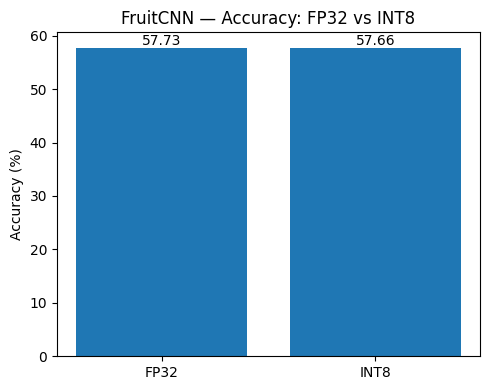

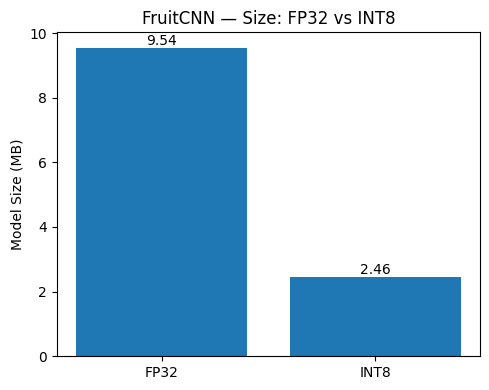

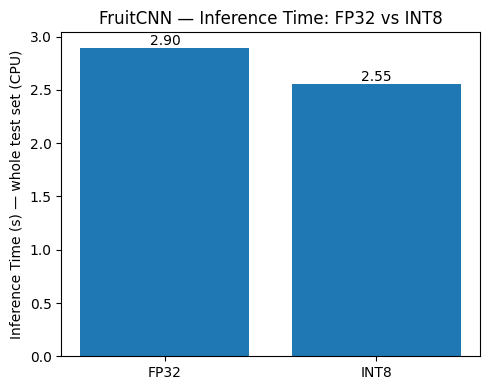

Speedup (FP32 / INT8): 1.13×
Saved plots:
 - ../experiments/plots/fruitcnn_acc_fp32_vs_int8.png
 - ../experiments/plots/fruitcnn_size_fp32_vs_int8.png
 - ../experiments/plots/fruitcnn_time_fp32_vs_int8.png


In [19]:

import os, json, math
from pathlib import Path
import matplotlib.pyplot as plt

# ---- Source the numbers ----
# Uses the variables from your previous cell; if missing, it will try to read the JSON you saved.
try:
    _acc_fp32 = acc_fp32; _acc_int8 = acc_int8
    _size_fp32 = size_fp32; _size_int8 = size_int8
    _time_fp32 = time_fp32; _time_int8 = time_int8
except NameError:
    with open("../experiments/results/fruitcnn_quantization_comparison.json", "r", encoding="utf-8") as f:
        r = json.load(f)["FruitCNN_Gray_MaxPool"]
    _acc_fp32 = r["fp32"]["accuracy"]; _acc_int8 = r["int8"]["accuracy"]
    _size_fp32 = r["fp32"]["size_mb"];  _size_int8 = r["int8"]["size_mb"]
    _time_fp32 = r["fp32"]["time_sec"]; _time_int8 = r["int8"]["time_sec"]

# ---- Prepare output dir & labels ----
plots_dir = Path("../experiments/plots")
plots_dir.mkdir(parents=True, exist_ok=True)

model_labels = ["FP32", "INT8"]
acc_vals  = [100*_acc_fp32, 100*_acc_int8]      # %
size_vals = [_size_fp32, _size_int8]            # MB
time_vals = [_time_fp32, _time_int8]            # seconds

# Helper to annotate bars with values
def _annotate_bars(ax, bars, fmt="{:.2f}"):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h,
                fmt.format(h),
                ha="center", va="bottom", fontsize=10)

# 1) Accuracy plot
plt.figure(figsize=(5,4))
bars = plt.bar(model_labels, acc_vals)
plt.ylabel("Accuracy (%)")
plt.title("FruitCNN — Accuracy: FP32 vs INT8")
_annotate_bars(plt.gca(), bars, "{:.2f}")
acc_path = plots_dir / "fruitcnn_acc_fp32_vs_int8.png"
plt.tight_layout()
plt.savefig(acc_path, dpi=160)
plt.show()

# 2) Model Size plot
plt.figure(figsize=(5,4))
bars = plt.bar(model_labels, size_vals)
plt.ylabel("Model Size (MB)")
plt.title("FruitCNN — Size: FP32 vs INT8")
_annotate_bars(plt.gca(), bars, "{:.2f}")
size_path = plots_dir / "fruitcnn_size_fp32_vs_int8.png"
plt.tight_layout()
plt.savefig(size_path, dpi=160)
plt.show()

# 3) Inference Time plot
plt.figure(figsize=(5,4))
bars = plt.bar(model_labels, time_vals)
plt.ylabel("Inference Time (s) — whole test set (CPU)")
plt.title("FruitCNN — Inference Time: FP32 vs INT8")
_annotate_bars(plt.gca(), bars, "{:.2f}")
time_path = plots_dir / "fruitcnn_time_fp32_vs_int8.png"
plt.tight_layout()
plt.savefig(time_path, dpi=160)
plt.show()

# 4) Speedup summary
speedup = _time_fp32 / _time_int8 if _time_int8 > 0 else float("inf")
print(f"Speedup (FP32 / INT8): {speedup:.2f}×")
print("Saved plots:")
print(" -", acc_path)
print(" -", size_path)
print(" -", time_path)
